# demo: lesioning face-selective units in torchvision models
#### jacob prince - 04/09/20

### procedure:

1) define custom lesioning model that inherits modules from a source network and accepts masks for each layer defining which, if any, units should have their activation set to 0 during a forward pass.

2) load model (alexnet/vgg16; no lesioning) and save activations to localizer images (20 faces, 20 scenes)

3) conduct floc experiment using data from #2 to define selective units; output is a selectivity mask for each layer

4) load new model (same arch; with lesioning) and save activations to test images (here, the same localizer set), with all face-selective units in the network lesioned

5) visualize activations to verify that lesioning was successful


## imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import os
from os.path import exists, join
import sys
from tqdm import tqdm
import time
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import torchvision.datasets as datasets 
from torchsummary import summary
from torch.autograd import Variable as V
from torch.nn import functional as F
import torch.nn  as nn
from PIL import Image
from IPython.core.debugger import set_trace
import scipy.io as sio
from time import sleep
import gc
import copy

import importlib
import nnutils as utils
import floc_selectivity as fs
import rsatools as rsa
import lesion as lsn

importlib.reload(fs)
importlib.reload(utils)
importlib.reload(rsa)
importlib.reload(lsn)

<module 'lesion' from '/home/jacobpri/git/RotspaceIT/notebooks/lesion.py'>

In [2]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

!nvidia-smi

No devices were found


In [13]:
# current implementation works for alexnet and vgg16
# close to working for resnet18 but they implement downsampling in a complicated way
arch = 'alexnet'
trained_on = 'object'
imageset = 'imagefiles-fullset'
img_dim = 224
batch_size = 50
FDR_threshold = 0.05
val_batch_size = 1000
subset_by = 1
lesioning_method = 'cascade-backward' # sledgehammer, cascade-forward, cascade-backward, single-layer
randomize_lesions = False
target_layer = 'fc7'
lesion_domain = 'Faces'
overwrite = True
searchlight = True

save_as = '.npy'
save_layer_rdvs = False
rdv_dist = 'correlation'
verbose = False
draw_plots = False

In [14]:
homedir = '/home/jacobpri/git/RotspaceIT/'
network = arch + '-' + trained_on
FDR_str = str(FDR_threshold).replace('.','_')
activation_savedir = join(homedir,'data','d02_modeling','activations',network,'localizer',imageset,'dim'+str(img_dim))
os.makedirs(activation_savedir,exist_ok=True)

In [17]:
imageset_dir = join(homedir,'imagesets','localizer',imageset)
assert(exists(imageset_dir))

val_imageset_dir = '/lab_data/tarrlab/common/datasets/ILSVRC/Data/CLS-LOC/val/'
assert(exists(val_imageset_dir))

floc_savedir = join(homedir,'data','d02_modeling','selectivity',network, 'localizer',imageset,'dim'+str(img_dim))
os.makedirs(floc_savedir,exist_ok=True)

utils.reproducible_results(365)

if lesioning_method == 'sledgehammer':
    target_str = ''
else:
    target_str = '_target-' + target_layer

lesion_resultsdir = join(homedir,'data','d02_modeling','lesioning',network,imageset)

results_str = f'LesionResults_dim-{img_dim}_FDR-{FDR_str}_subset-{subset_by}_method-{lesioning_method}_random-{str(randomize_lesions)}{target_str}_searchlight-{searchlight}_domain-{lesion_domain}'

os.makedirs(lesion_resultsdir,exist_ok=True)

print(results_str)

LesionResults_dim-224_FDR-0_05_subset-1_method-cascade-backward_random-False_target-fc7_searchlight-True_domain-Faces


In [18]:
FDR_str = str(FDR_threshold).replace('.','_')
fn = join(lesion_resultsdir,results_str + '.npy')
        
results = np.load(fn,allow_pickle=True).item()

masks = dict()
model = lsn.LesionNet(models.alexnet(), masks)

In [19]:
def lesion_scatter_corr(x,
                        y,
                        epsilon=0.0075,
                        corr_line=False,
                        xy_line=False,
                        title='',
                        xlabel='',
                        ylabel='',
                        jitter_x=True,
                        jitter_y=True,
                        col_animacy=True,
                        dotsize=5,
                        alpha=0.5,
                        animacy_colors=['r','b']):
    
    jitter = np.random.normal(0,epsilon,len(x))
    
    if jitter_x:
        x = x + jitter
    if jitter_y:
        y = y + jitter
        
    if col_animacy and len(x) == 1000 and len(y) == 1000:
        
        plt.scatter(x[:500],y[:500],dotsize,animacy_colors[0],alpha=alpha)
        plt.scatter(x[500:],y[500:],dotsize,animacy_colors[1],alpha=alpha)
    else:
        plt.scatter(x,y,dotsize,'k',alpha=alpha)
        
    if corr_line:
        plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),'k')
    if xy_line:
        minval, maxval = np.min(np.concatenate((x,y))), np.max(np.concatenate((x,y)))
        plt.plot(np.arange(minval,maxval,0.1), np.arange(minval,maxval,0.1),'g--',linewidth=2)
        
    plt.axis('square')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    return round(np.corrcoef(x,y)[1,0],3)
        
        
    

file does not exist
/home/jacobpri/git/RotspaceIT/data/d02_modeling/lesioning/alexnet-object/imagefiles-fullset/LesionResults_dim-224_FDR-0_05_subset-1_method-cascade-backward_random-True_target-conv1_searchlight-True_domain-Faces.npy
file does not exist
/home/jacobpri/git/RotspaceIT/data/d02_modeling/lesioning/alexnet-object/imagefiles-fullset/LesionResults_dim-224_FDR-0_05_subset-1_method-cascade-backward_random-True_target-relu1_searchlight-True_domain-Faces.npy
file does not exist
/home/jacobpri/git/RotspaceIT/data/d02_modeling/lesioning/alexnet-object/imagefiles-fullset/LesionResults_dim-224_FDR-0_05_subset-1_method-cascade-backward_random-True_target-maxpool1_searchlight-True_domain-Faces.npy
file does not exist
/home/jacobpri/git/RotspaceIT/data/d02_modeling/lesioning/alexnet-object/imagefiles-fullset/LesionResults_dim-224_FDR-0_05_subset-1_method-cascade-backward_random-True_target-conv2_searchlight-True_domain-Faces.npy
file does not exist
/home/jacobpri/git/RotspaceIT/data/d0

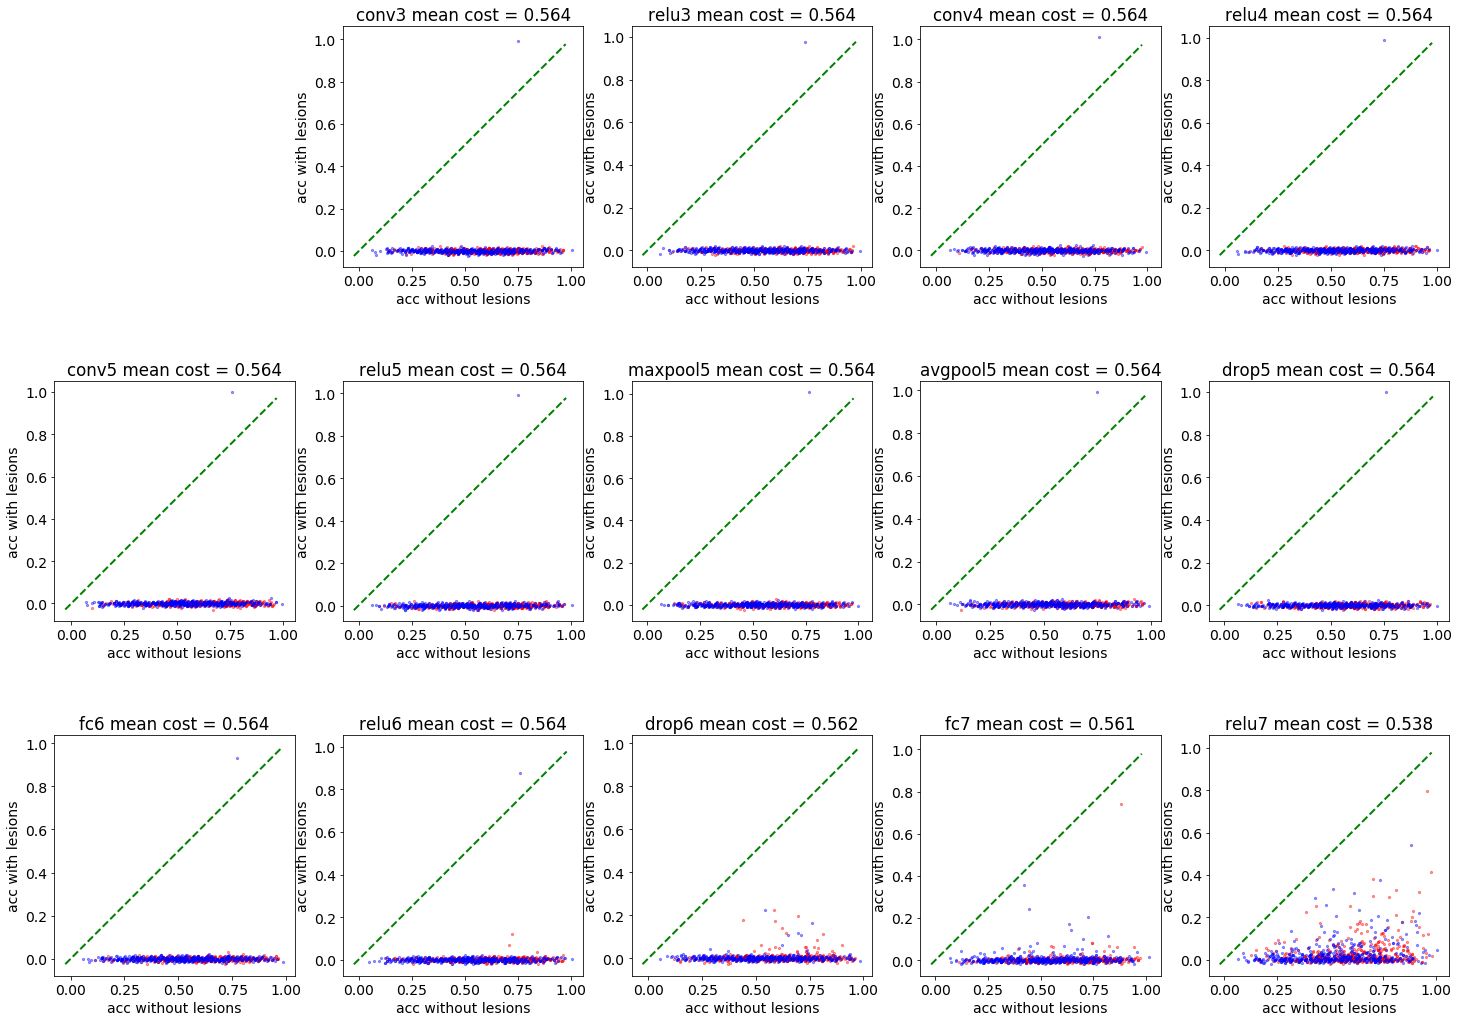

In [38]:
lesioning_method = 'cascade-backward'
for lesion_domain in ['Faces']:#,'Scenes']:
    randomize_lesions = True

    plt.figure
    n = len(model.layers)
    plt.figure(figsize=(25,25))
    c = 1
    mean_costs = []
    for lay in model.layers[:-1]:

        if lesioning_method == 'sledgehammer':
            target_str = ''
        else:
            target_str = '_target-' + lay

        results_str = f'LesionResults_dim-{img_dim}_FDR-{FDR_str}_subset-{subset_by}_method-{lesioning_method}_random-{str(randomize_lesions)}{target_str}_searchlight-{searchlight}_domain-{lesion_domain}'

        fn = join(lesion_resultsdir,results_str + '.npy')

        try:
            results = np.load(fn,allow_pickle=True).item()

            plt.subplot(n//5,n//4,c)

            x = results['no_lesion']['accuracies'] 
            y = results[lesion_domain]['accuracies']

            _ = lesion_scatter_corr(x,y,
                                    title=f'{lay} mean cost = {round(np.mean(x-y),3)}',
                                    alpha=0.4,
                                    xy_line=True,
                                    xlabel='acc without lesions',
                                    ylabel='acc with lesions')

            mean_costs.append(np.nanmean(x-y))

        except:
            print('file does not exist')
            print(fn)

        c+=1

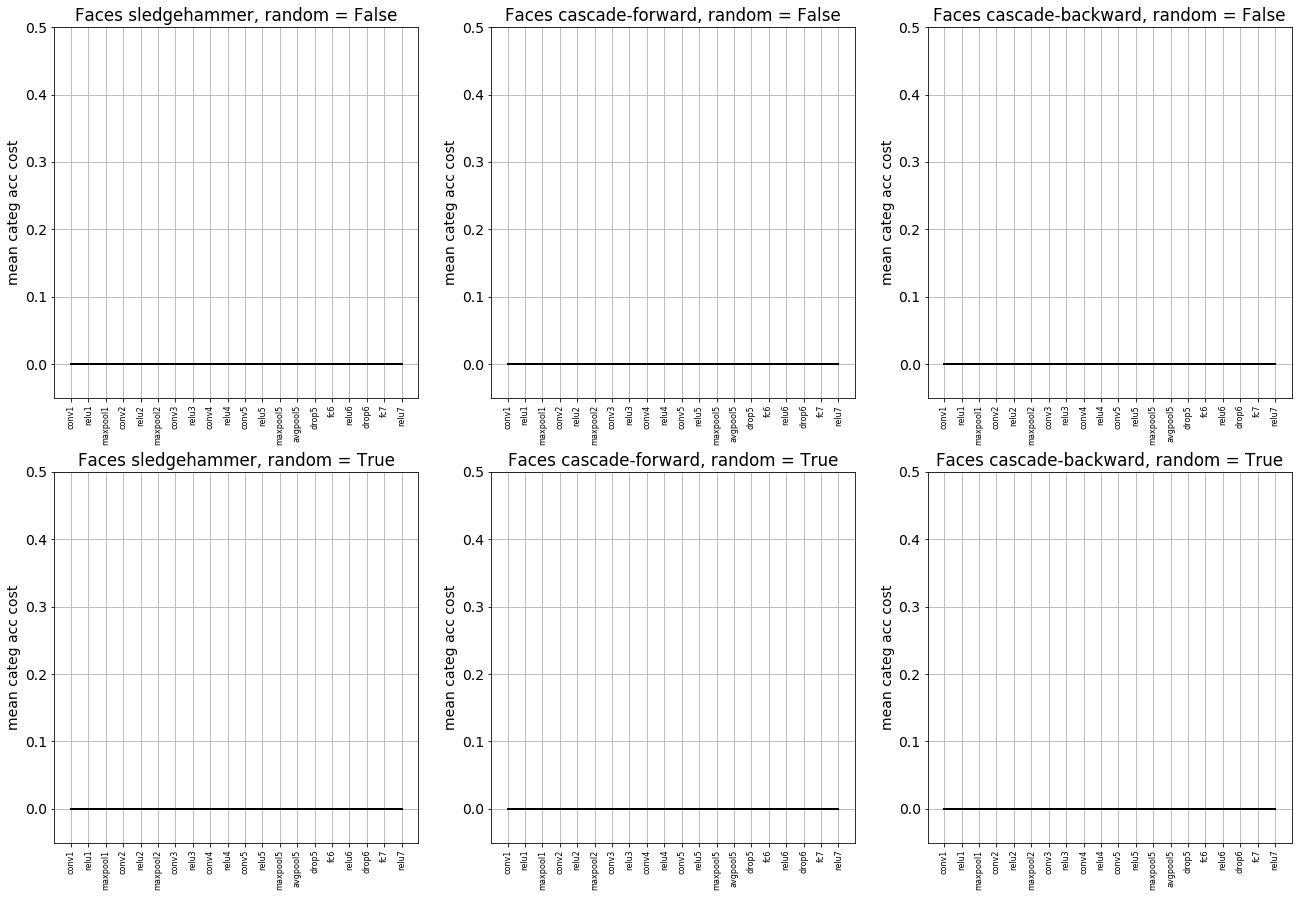

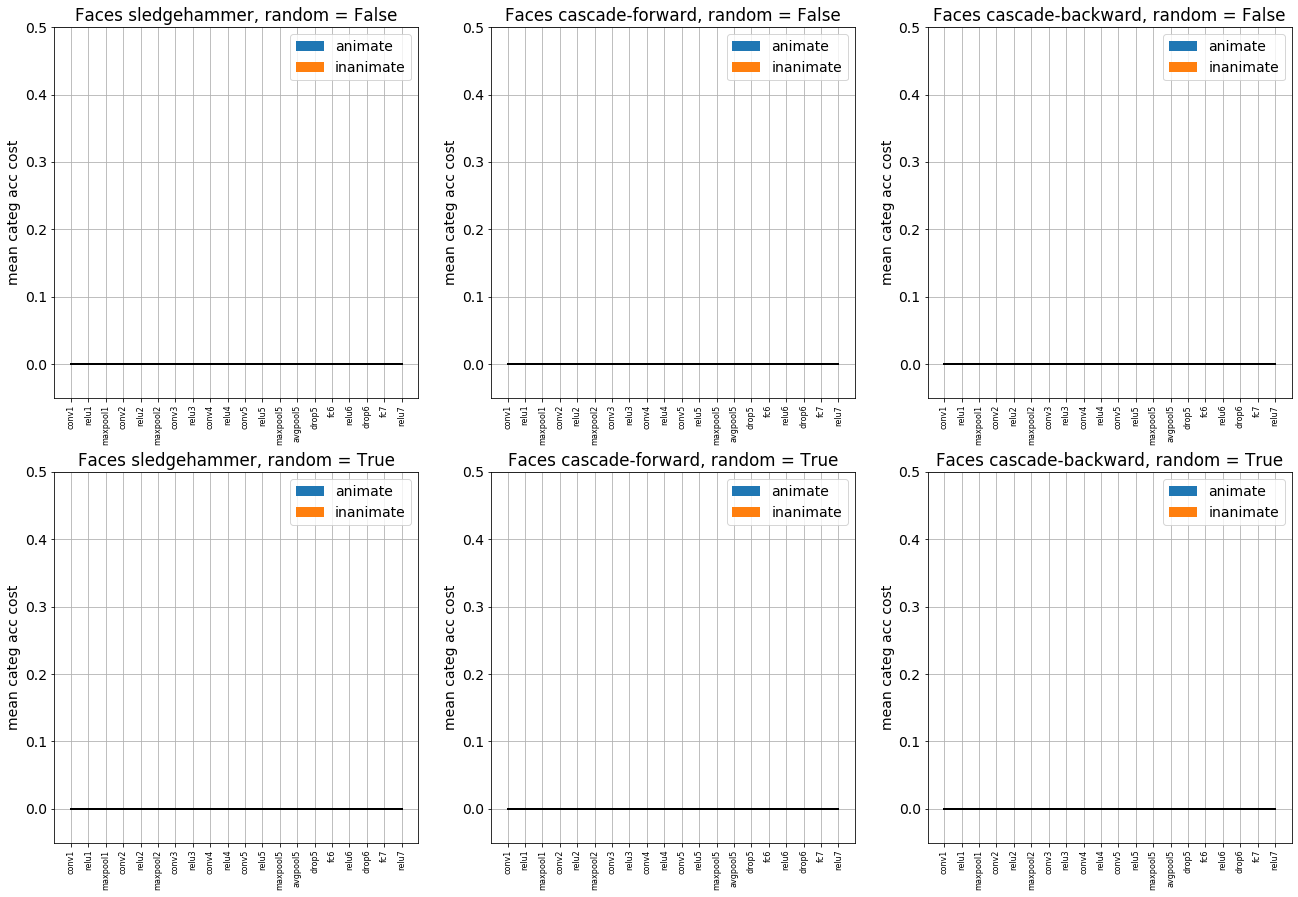

In [27]:
plt.rcParams.update({'font.size': 14})

subplot_order=[1,5,2,6,3,7,4,8]

for animacy_breakdown in [False, True]:

    for lesion_domain in ['Faces']:#,'Scenes']:
        fig1 = plt.figure(figsize=(30,15))
        c=0
        for lesioning_method in ['sledgehammer','cascade-forward','cascade-backward']:#,'single-layer']:
            for randomize_lesions in [False, True]:
                mean_costs = []
                mean_animate_costs = []
                mean_inanimate_costs = []
                std_costs = []
                std_animate_costs = []
                std_inanimate_costs = []
                for lay in model.layers[:-1]:

                    if lesioning_method == 'sledgehammer':
                        target_str = ''
                    else:
                        target_str = '_target-' + lay

                    results_str = f'LesionResults_dim-{img_dim}_FDR-{FDR_str}_subset-{subset_by}_method-{lesioning_method}_random-{str(randomize_lesions)}{target_str}_searchlight={searchlight}_domain-{lesion_domain}'

                    fn = join(lesion_resultsdir,results_str + '.npy')

                    try:
                        results = np.load(fn,allow_pickle=True).item()
                        x = results['no_lesion']['accuracies'] 
                        y = results[lesion_domain]['accuracies']

                        mean_costs.append(np.nanmean(x-y))
                        mean_animate_costs.append(np.nanmean(x[:500]-y[:500]))
                        mean_inanimate_costs.append(np.nanmean(x[500:]-y[500:]))

                        std_costs.append(np.nanstd(x-y))
                        std_animate_costs.append(np.nanstd(x[:500]-y[:500]))
                        std_inanimate_costs.append(np.nanstd(x[500:]-y[500:]))

                    except:
                        #print('file does not exist')
                        #print(fn)
                        mean_costs.append(np.nan)
                        mean_animate_costs.append(np.nan)
                        mean_inanimate_costs.append(np.nan)

                        std_costs.append(np.nan)
                        std_animate_costs.append(np.nan)
                        std_inanimate_costs.append(np.nan)

                if animacy_breakdown:
                    plt.subplot(2,4,subplot_order[c])
                    p1 = plt.bar(np.arange(len(model.layers[:-1]))-0.25, mean_animate_costs, width=0.2)
                    p2 = plt.bar(np.arange(len(model.layers[:-1]))+0.25, mean_inanimate_costs, width=0.2)

                    plt.legend((p1[0], p2[0]), ('animate', 'inanimate'))
                else:
                    plt.subplot(2,4,subplot_order[c])
                    p1 = plt.bar(np.arange(len(model.layers[:-1])), mean_costs, width=0.75)

                plt.ylim([-0.05,0.5])
                plt.title(f'{lesion_domain} {lesioning_method}, random = {randomize_lesions}')
                plt.xticks(np.arange(len(model.layers[:-1])),np.array(model.layers[:-1]),rotation=90,fontsize=8)
                plt.grid(True)
                plt.ylabel('mean categ acc cost')
                plt.plot(np.arange(0,20),np.zeros((20,)),'k',linewidth=2)
                c+=1



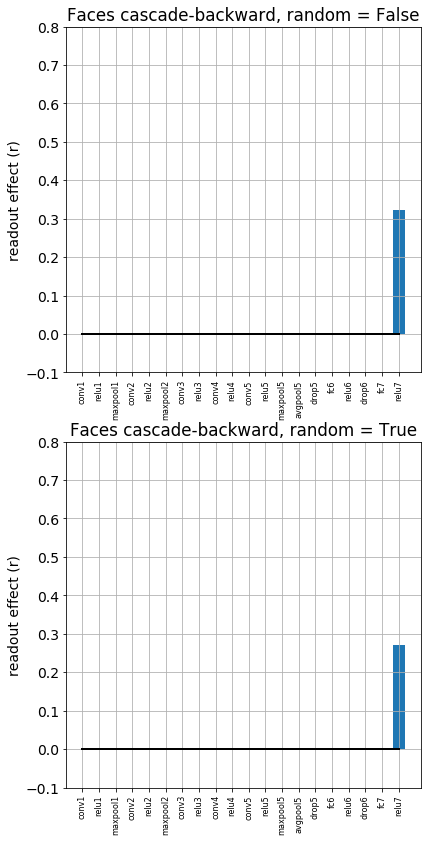

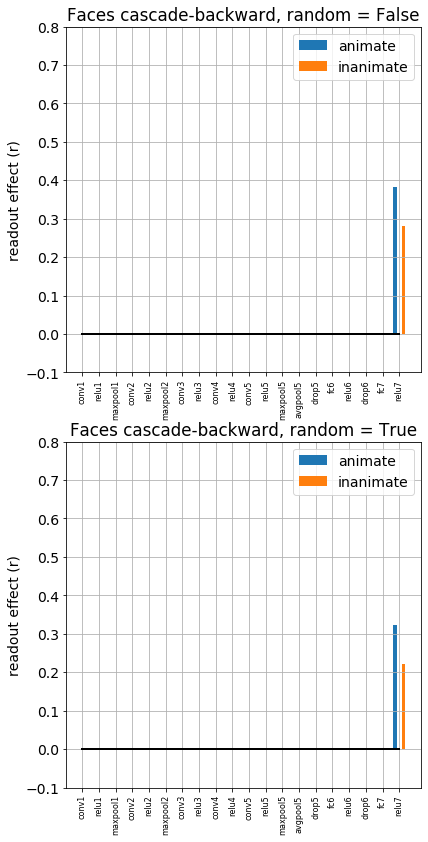

In [34]:
subplot_order=[1,3,2,4]

for animacy_breakdown in [False, True]:
    fig1 = plt.figure(figsize=(14,14))
    c=0
    for lesion_domain in ['Faces']:#,'Scenes']:

        for lesioning_method in ['cascade-backward']:#,'cascade-forward','cascade-backward','single-layer']:
            for randomize_lesions in [False, True]:
                readout_r = []
                animate_readout_r = []
                inanimate_readout_r = []

                if lesioning_method == 'sledgehammer':
                    target_str = ''
                else:
                    target_str = '_target-' + lay

                results_str = f'LesionResults_dim-{img_dim}_FDR-{FDR_str}_subset-{subset_by}_method-{lesioning_method}_random-{str(randomize_lesions)}{target_str}_searchlight-{searchlight}_domain-{lesion_domain}'

                fn = join(lesion_resultsdir,results_str + '.npy')

                try:
                    results = np.load(fn,allow_pickle=True).item()


                    for i in range(len(model.layers)-1):
                        lay = model.layers[i]
                        x = results['no_lesion']['selective_unit_acts'][lesion_domain][lay]
                        y = results['no_lesion']['accuracies'] - results[lesion_domain]['accuracies']
                        corr = np.corrcoef(x,y)[1,0]
                        readout_r.append(round(corr,4))
                        
                        animate_corr = np.corrcoef(x[:500],y[:500])[1,0]
                        inanimate_corr = np.corrcoef(x[500:],y[500:])[1,0]
                        animate_readout_r.append(round(animate_corr,4))
                        inanimate_readout_r.append(round(inanimate_corr,4))


                except:

                    readout_r.append(np.nan)

                if animacy_breakdown:
                    plt.subplot(2,2,subplot_order[c])
                    p1 = plt.bar(np.arange(len(model.layers[:-1]))-0.25, animate_readout_r, width=0.2)
                    p2 = plt.bar(np.arange(len(model.layers[:-1]))+0.25, inanimate_readout_r, width=0.2)

                    plt.legend((p1[0], p2[0]), ('animate', 'inanimate'))
                else:
                    plt.subplot(2,2,subplot_order[c])
                    p1 = plt.bar(np.arange(len(model.layers[:-1])), readout_r, width=0.75)

                plt.ylim([-0.1,0.8])
                plt.title(f'{lesion_domain} {lesioning_method}, random = {randomize_lesions}')
                plt.xticks(np.arange(len(model.layers[:-1])),np.array(model.layers[:-1]),rotation=90,fontsize=8)
                plt.grid(True)
                plt.ylabel('readout effect (r)')
                plt.plot(np.arange(0,20),np.zeros((20,)),'k',linewidth=2)
                c+=1



/home/jacobpri/git/RotspaceIT/data/d02_modeling/lesioning/alexnet-object/imagefiles-fullset/LesionResults_dim-224_FDR-0_05_subset-1_method-cascade-backward_random-False_target-conv1_searchlight-True_domain-Faces.npy
/home/jacobpri/git/RotspaceIT/data/d02_modeling/lesioning/alexnet-object/imagefiles-fullset/LesionResults_dim-224_FDR-0_05_subset-1_method-cascade-backward_random-False_target-relu1_searchlight-True_domain-Faces.npy
/home/jacobpri/git/RotspaceIT/data/d02_modeling/lesioning/alexnet-object/imagefiles-fullset/LesionResults_dim-224_FDR-0_05_subset-1_method-cascade-backward_random-False_target-maxpool1_searchlight-True_domain-Faces.npy
/home/jacobpri/git/RotspaceIT/data/d02_modeling/lesioning/alexnet-object/imagefiles-fullset/LesionResults_dim-224_FDR-0_05_subset-1_method-cascade-backward_random-False_target-conv2_searchlight-True_domain-Faces.npy
/home/jacobpri/git/RotspaceIT/data/d02_modeling/lesioning/alexnet-object/imagefiles-fullset/LesionResults_dim-224_FDR-0_05_subset-1_m

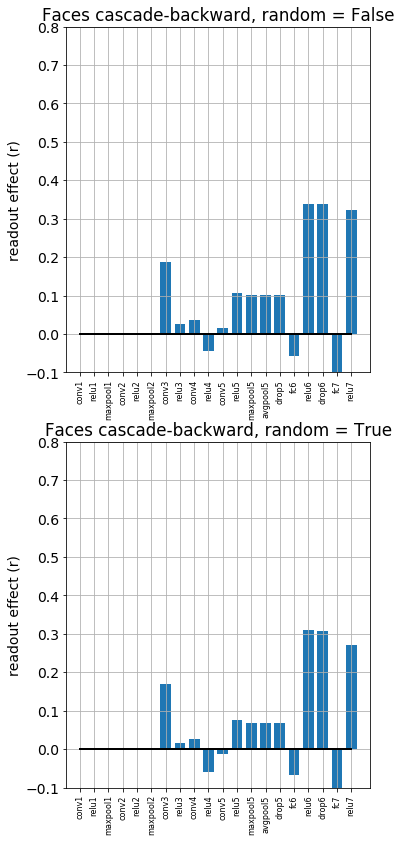

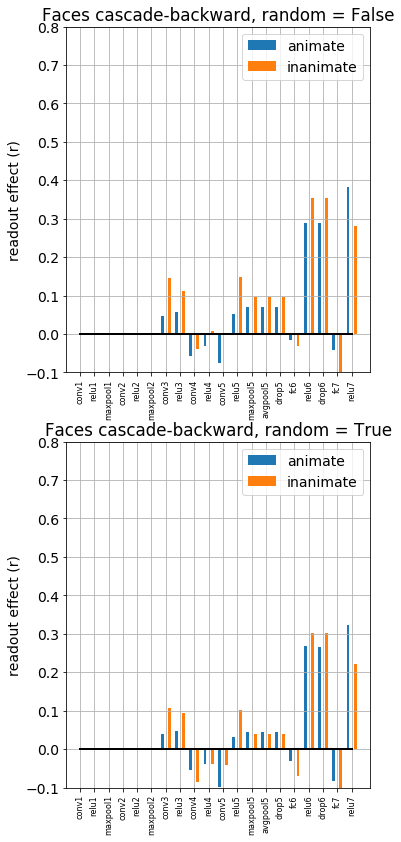

In [33]:
subplot_order=[1,3,2,4]

for animacy_breakdown in [False, True]:
    fig1 = plt.figure(figsize=(12,14))
    c=0
    for lesion_domain in ['Faces']:#,'Scenes']:

        for lesioning_method in ['cascade-backward']:#,'cascade-forward','cascade-backward','single-layer']:
            for randomize_lesions in [False, True]:
                readout_r = []
                animate_readout_r = []
                inanimate_readout_r = []
                
                for i in range(len(model.layers)-1):
                    
                    lay = model.layers[i]
                    
                    if lesioning_method == 'sledgehammer':
                        target_str = ''
                    else:
                        target_str = '_target-' + lay

                    results_str = f'LesionResults_dim-{img_dim}_FDR-{FDR_str}_subset-{subset_by}_method-{lesioning_method}_random-{str(randomize_lesions)}{target_str}_searchlight-{searchlight}_domain-{lesion_domain}'

                    fn = join(lesion_resultsdir,results_str + '.npy')

                    try:
                        results = np.load(fn,allow_pickle=True).item()

                        
                        x = results['no_lesion']['selective_unit_acts'][lesion_domain][lay]
                        y = results['no_lesion']['accuracies'] - results[lesion_domain]['accuracies']
                        corr = np.corrcoef(x,y)[1,0]
                        readout_r.append(round(corr,4))

                        animate_corr = np.corrcoef(x[:500],y[:500])[1,0]
                        inanimate_corr = np.corrcoef(x[500:],y[500:])[1,0]
                        animate_readout_r.append(round(animate_corr,4))
                        inanimate_readout_r.append(round(inanimate_corr,4))

                    except:
                        print(fn)
                        readout_r.append(np.nan)
                        animate_readout_r.append(np.nan)
                        inanimate_readout_r.append(np.nan)

                if animacy_breakdown:
                    plt.subplot(2,2,subplot_order[c])
                    p1 = plt.bar(np.arange(len(model.layers[:-1]))-0.25, animate_readout_r, width=0.2)
                    p2 = plt.bar(np.arange(len(model.layers[:-1]))+0.25, inanimate_readout_r, width=0.2)

                    plt.legend((p1[0], p2[0]), ('animate', 'inanimate'))
                else:
                    plt.subplot(2,2,subplot_order[c])
                    p1 = plt.bar(np.arange(len(model.layers[:-1])), readout_r, width=0.75)

                plt.ylim([-0.1,0.8])
                plt.title(f'{lesion_domain} {lesioning_method}, random = {randomize_lesions}')
                plt.xticks(np.arange(len(model.layers[:-1])),np.array(model.layers[:-1]),rotation=90,fontsize=8)
                plt.grid(True)
                plt.ylabel('readout effect (r)')
                plt.plot(np.arange(0,20),np.zeros((20,)),'k',linewidth=2)
                c+=1



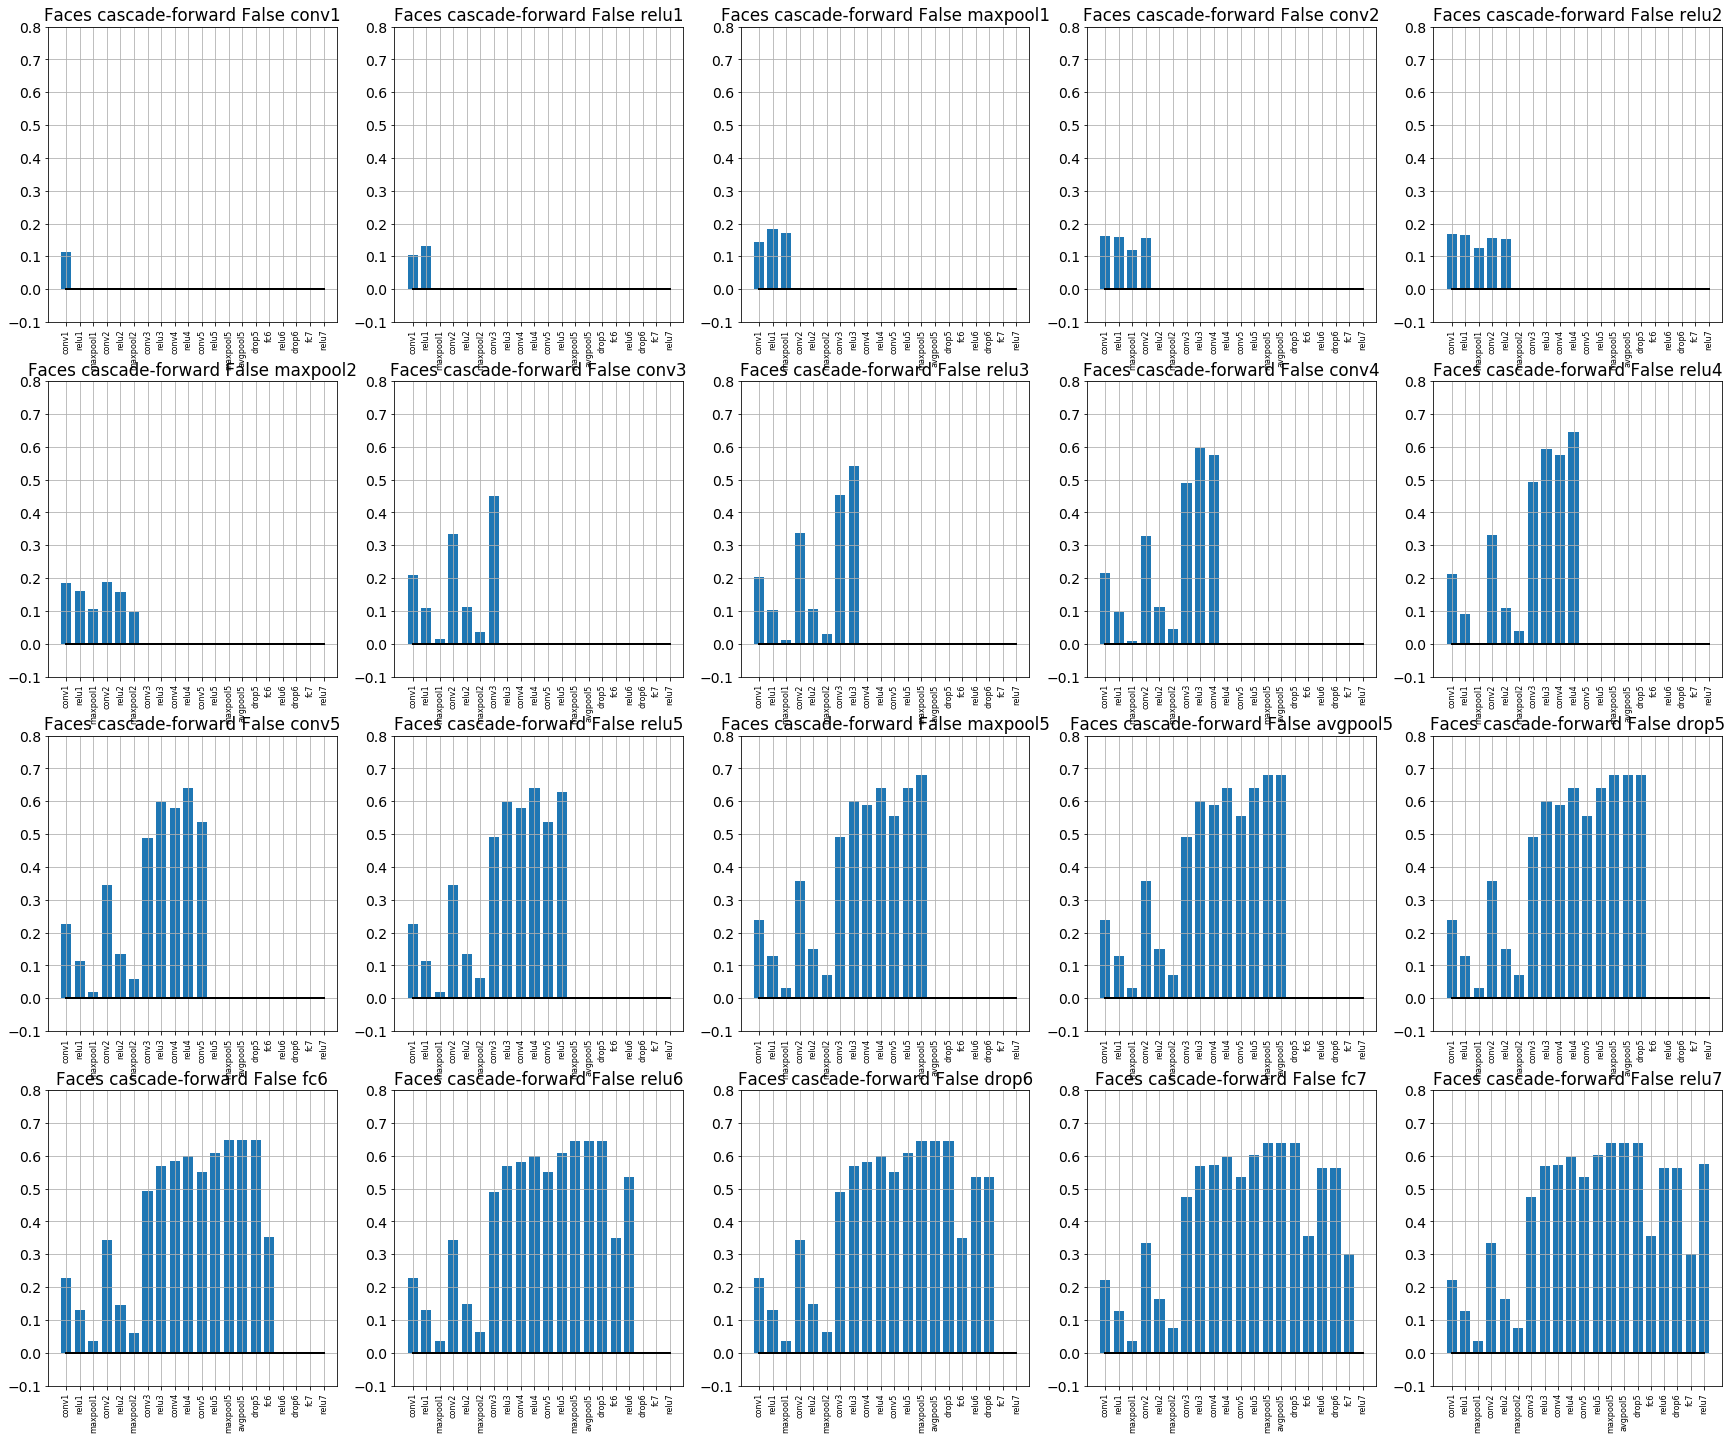

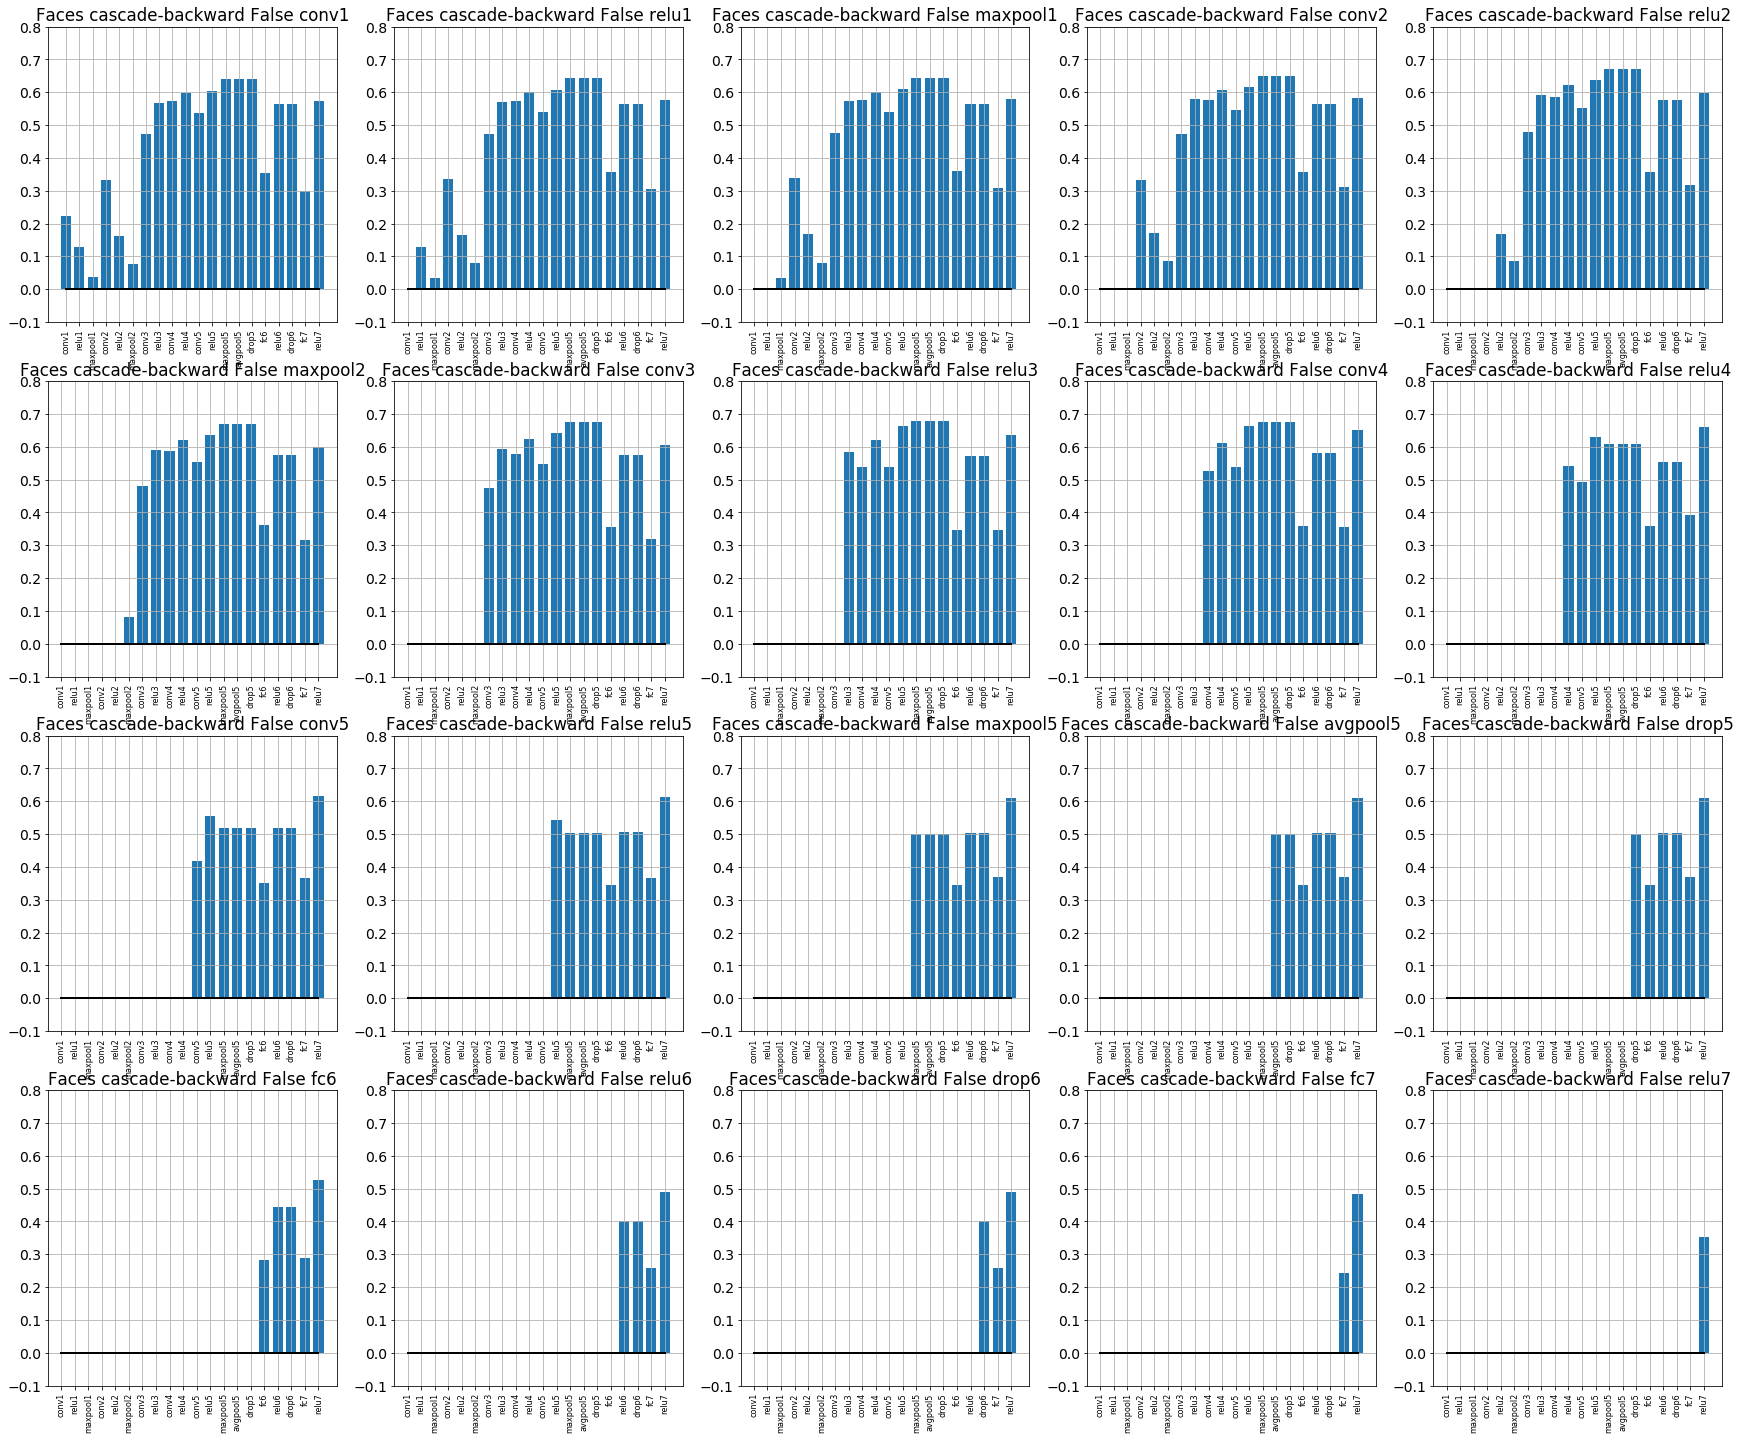

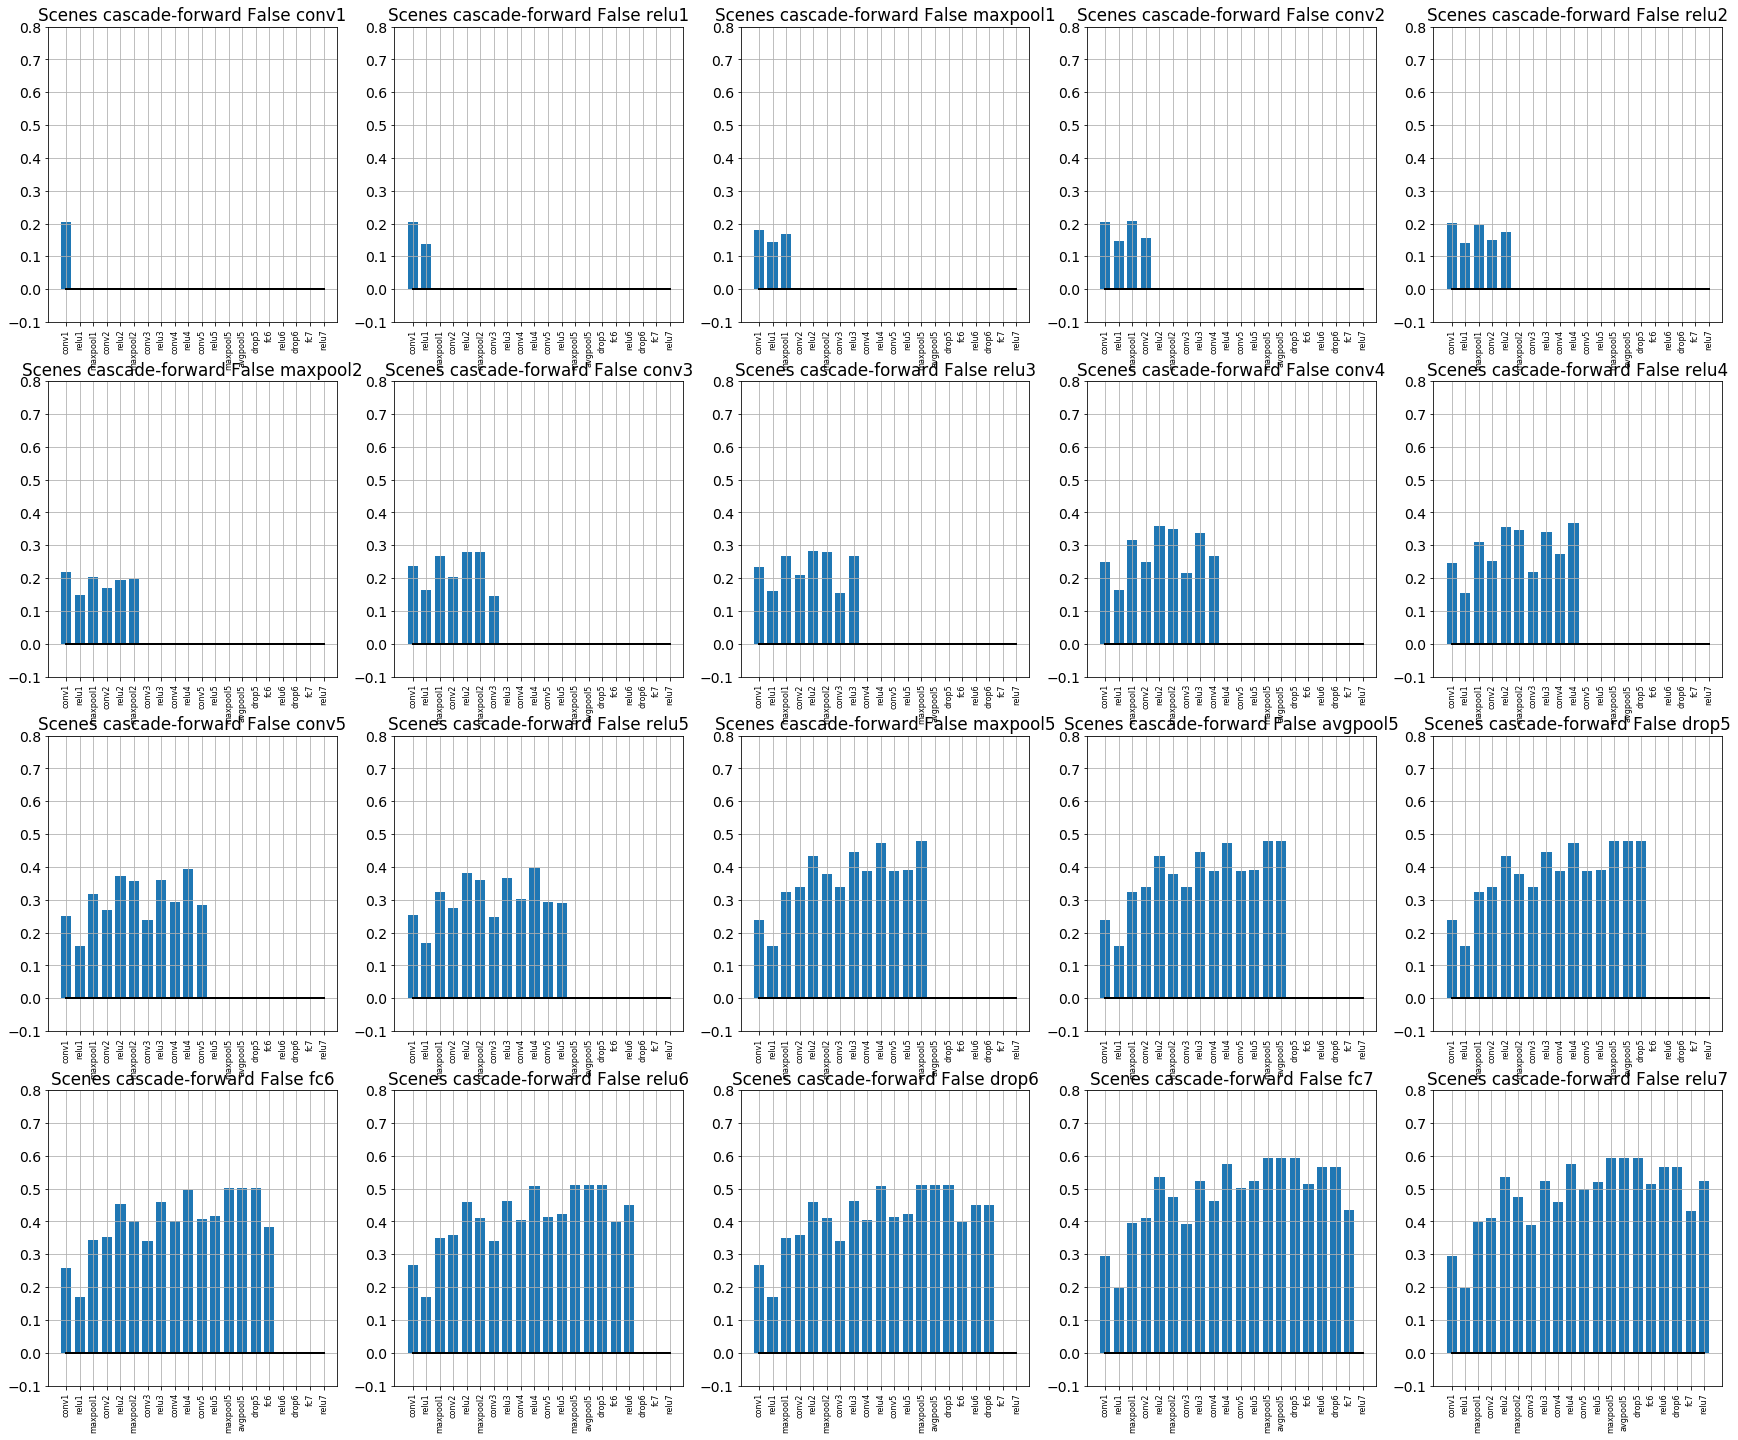

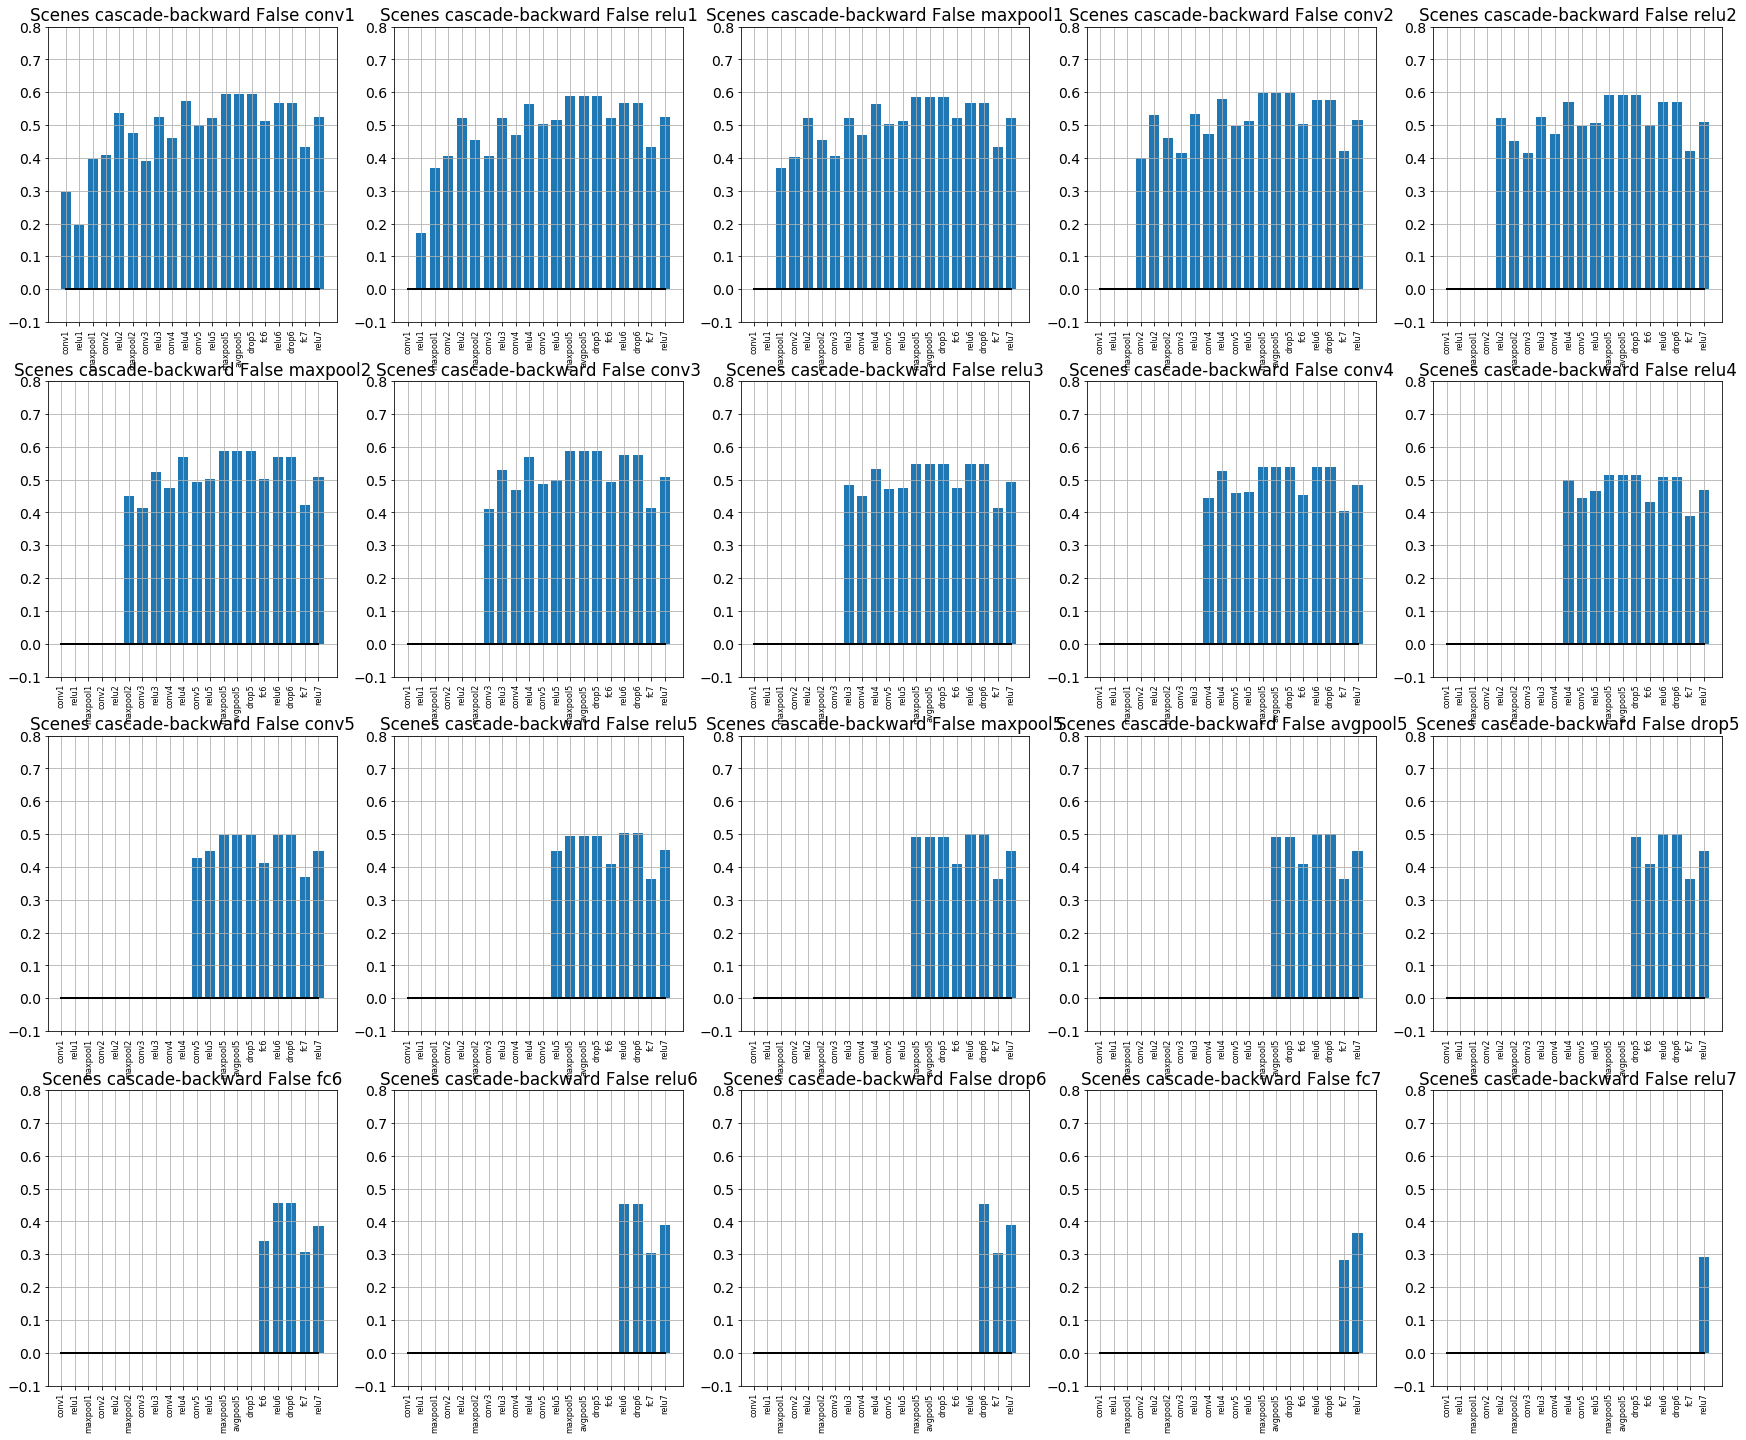

In [283]:
skip = False
if not skip:
    for animacy_breakdown in [False]:
        all_peak_vals = []
        all_method_strs = []
        for lesion_domain in ['Faces','Scenes']:

            for lesioning_method in ['cascade-forward', 'cascade-backward']:#,'cascade-forward','cascade-backward','single-layer']:
                for randomize_lesions in [False]:

                    fig1 = plt.figure(figsize=(30,25))
                    c=1
                    peak_vals = []

                    for i in range(len(model.layers)-1):

                        lay = model.layers[i]

                        if lesioning_method == 'sledgehammer':
                            target_str = ''
                        else:
                            target_str = '_target-' + lay

                        results_str = f'LesionResults_dim-{img_dim}_FDR-{FDR_str}_subset-{subset_by}_method-{lesioning_method}_random-{str(randomize_lesions)}{target_str}_domain-{lesion_domain}'

                        fn = join(lesion_resultsdir,results_str + '.npy')

                        readout_r = []
                        animate_readout_r = []
                        inanimate_readout_r = []

                        try:
                            results = np.load(fn,allow_pickle=True).item()

                            for ii in range(len(model.layers)-1):

                                lay_ = model.layers[ii]

                                x = results['no_lesion']['selective_unit_acts'][lesion_domain][lay_]
                                y = results['no_lesion']['accuracies'] - results[lesion_domain]['accuracies']
                                corr = np.corrcoef(x,y)[1,0]
                                readout_r.append(round(corr,4))

                                animate_corr = np.corrcoef(x[:500],y[:500])[1,0]
                                inanimate_corr = np.corrcoef(x[500:],y[500:])[1,0]
                                animate_readout_r.append(round(animate_corr,4))
                                inanimate_readout_r.append(round(inanimate_corr,4))

                        except:
                            print(fn)
                            readout_r.append(np.nan)
                            animate_readout_r.append(np.nan)
                            inanimate_readout_r.append(np.nan)

                        if animacy_breakdown:
                            plt.subplot(4,5,c)
                            p1 = plt.bar(np.arange(len(model.layers[:-1]))-0.25, animate_readout_r, width=0.2)
                            p2 = plt.bar(np.arange(len(model.layers[:-1]))+0.25, inanimate_readout_r, width=0.2)

                            plt.legend((p1[0], p2[0]), ('animate', 'inanimate'))
                        else:
                            plt.subplot(4,5,c)
                            p1 = plt.bar(np.arange(len(model.layers[:-1])), readout_r, width=0.75)

                        plt.ylim([-0.1,0.8])
                        plt.title(f'{lesion_domain} {lesioning_method} {randomize_lesions} {lay}')
                        plt.xticks(np.arange(len(model.layers[:-1])),np.array(model.layers[:-1]),rotation=90,fontsize=8)
                        plt.grid(True)
                        plt.plot(np.arange(0,20),np.zeros((20,)),'k',linewidth=2)
                        c+=1

                        peak_vals.append(np.nanmax(readout_r))

                    plt.show()

                    all_peak_vals.append(peak_vals)
                    all_method_strs.append(f'{lesion_domain} {lesioning_method} {randomize_lesions}')
                    
    


Text(0.5, 1.0, 'maximum layer read-out effect value in network\nvs. layer where cascading is stopped')

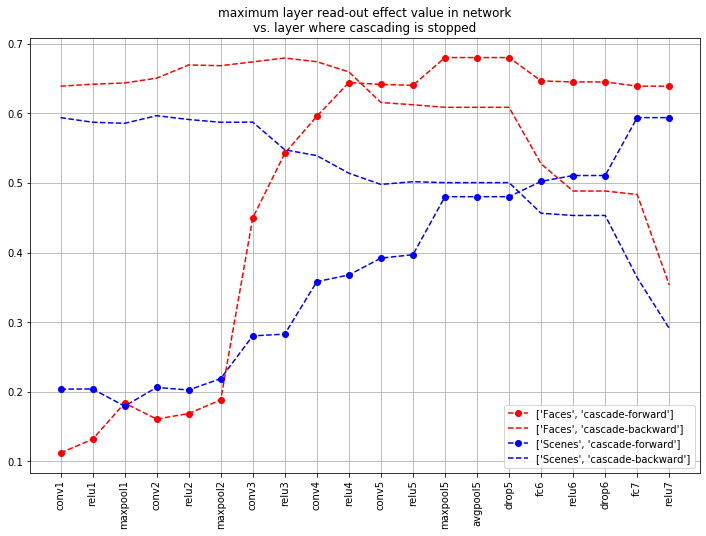

In [248]:
colors=['ro--','mo--','r--','m--','bo--','co--','b--','c--']

plt.figure(figsize=(12,8))
for p in range(0,len(all_peak_vals),2):
    plt.plot(all_peak_vals[p],colors[p],label=all_method_strs[p].split(' ')[:-1])
plt.legend()
plt.xticks(np.arange(len(model.layers)-1),np.array(model.layers[:-1]),rotation=90);
plt.grid(True)
plt.title('maximum layer read-out effect value in network\nvs. layer where cascading is stopped')
    
# first: what is the read-out effect actually measuring?
# it measures the extent to which you can PREDICT how much the network will fail at a categ from the degree to 
# which that categ activates the selective subset under normal circumstances.
# if this is high, it means that you can better infer the functional role of a dn-FA/PA based on its categ univariate acts

# notes on cascade forward:
# not much of a readout effect for faces or scenes when lesioning up to the end of block 2
# lesioning additional face units of blocks 3 and 4 induces dramatic readout effect in faces, less so for scenes
# increasing strength of readout effect for scenes is pretty linear vs. faces which leaps up and plateaus
# lesioning face units in fc blocks actually damps down the peak readout effect observed - this is not true for scenes

# notes on cascade backward
# lesioning units near the end of the network induce a much stronger readout effect than lesioning units near the front
# (probably this is to be expected)
# both face and scene peak readout effects get stronger as you lesion further and further back, trend is similar. faces >

# notes comparing both
# very different story when cascading backward vs. forward, interestingly... look at trend divergence in forward case
# crossing points:
# the strength of the peak readout effect in the face case is about equal when lesioning up to OR beyond block 4.
# for scenes, this "crossing point" is later, at around fc6
# this implies that in the face case, earlier dnFAs carry proportionally more info about readout than later dnFAs,
# and for scenes, later dnPAs carry proportionally more info about readout than earlier dnPAs

# you'd need to lesion thousands and thousands of scene selective units going forward all the way to fc6 in order to elicit
# the same readout effect in the network as if you just lesioned the final four layers.


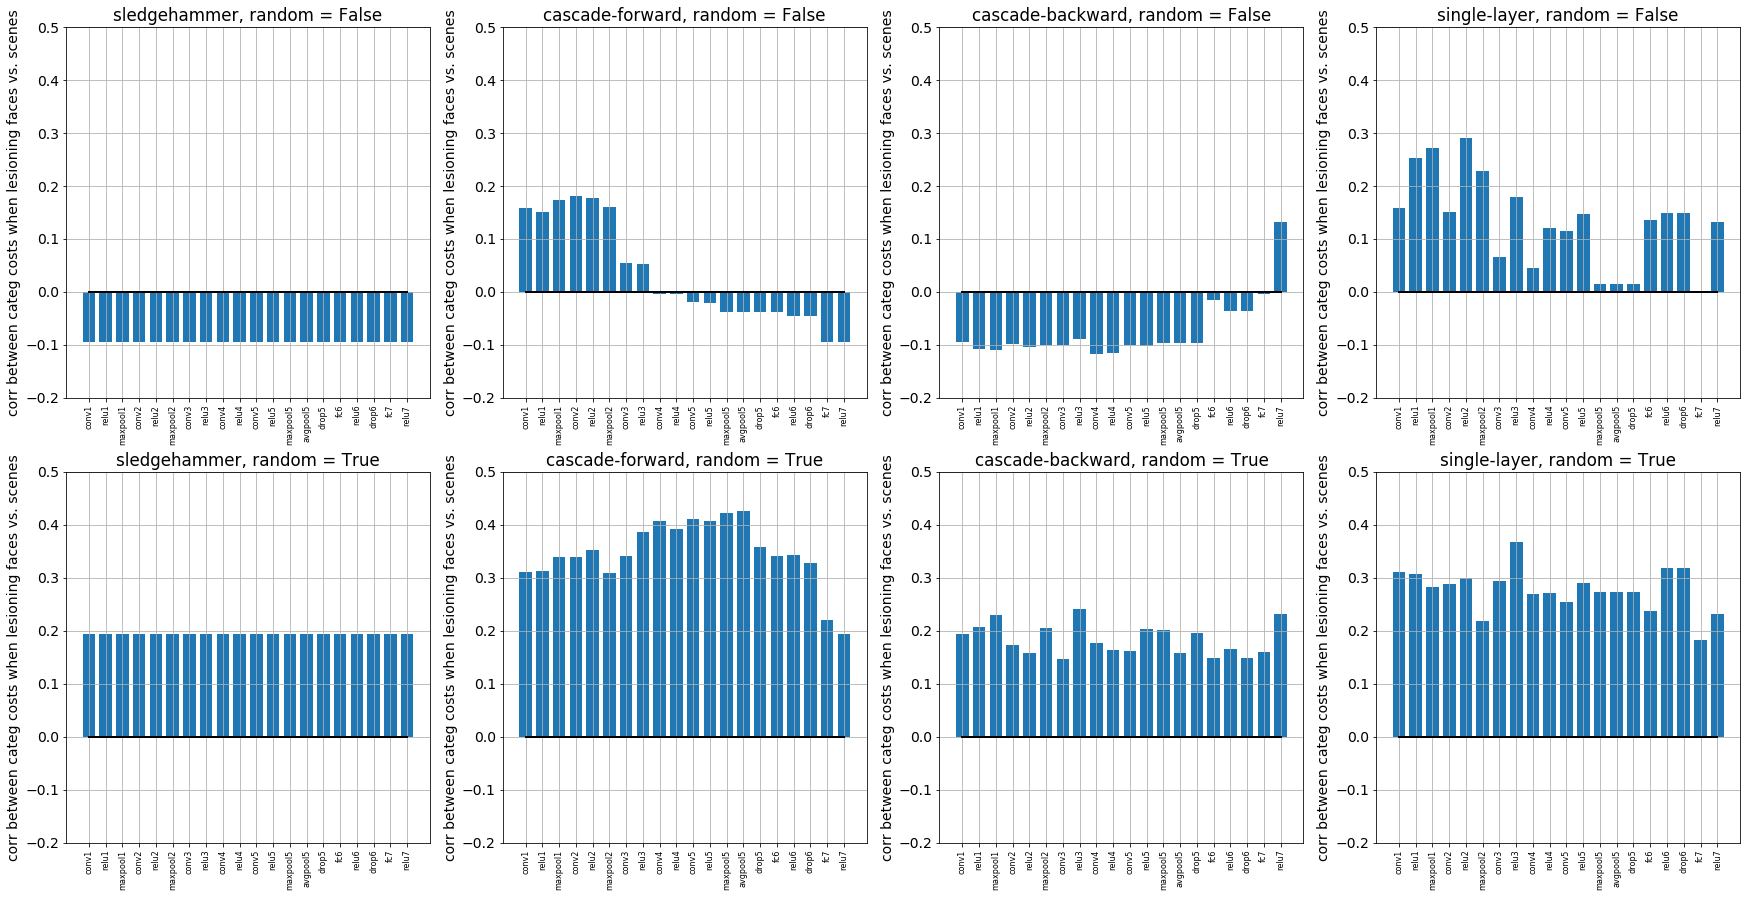

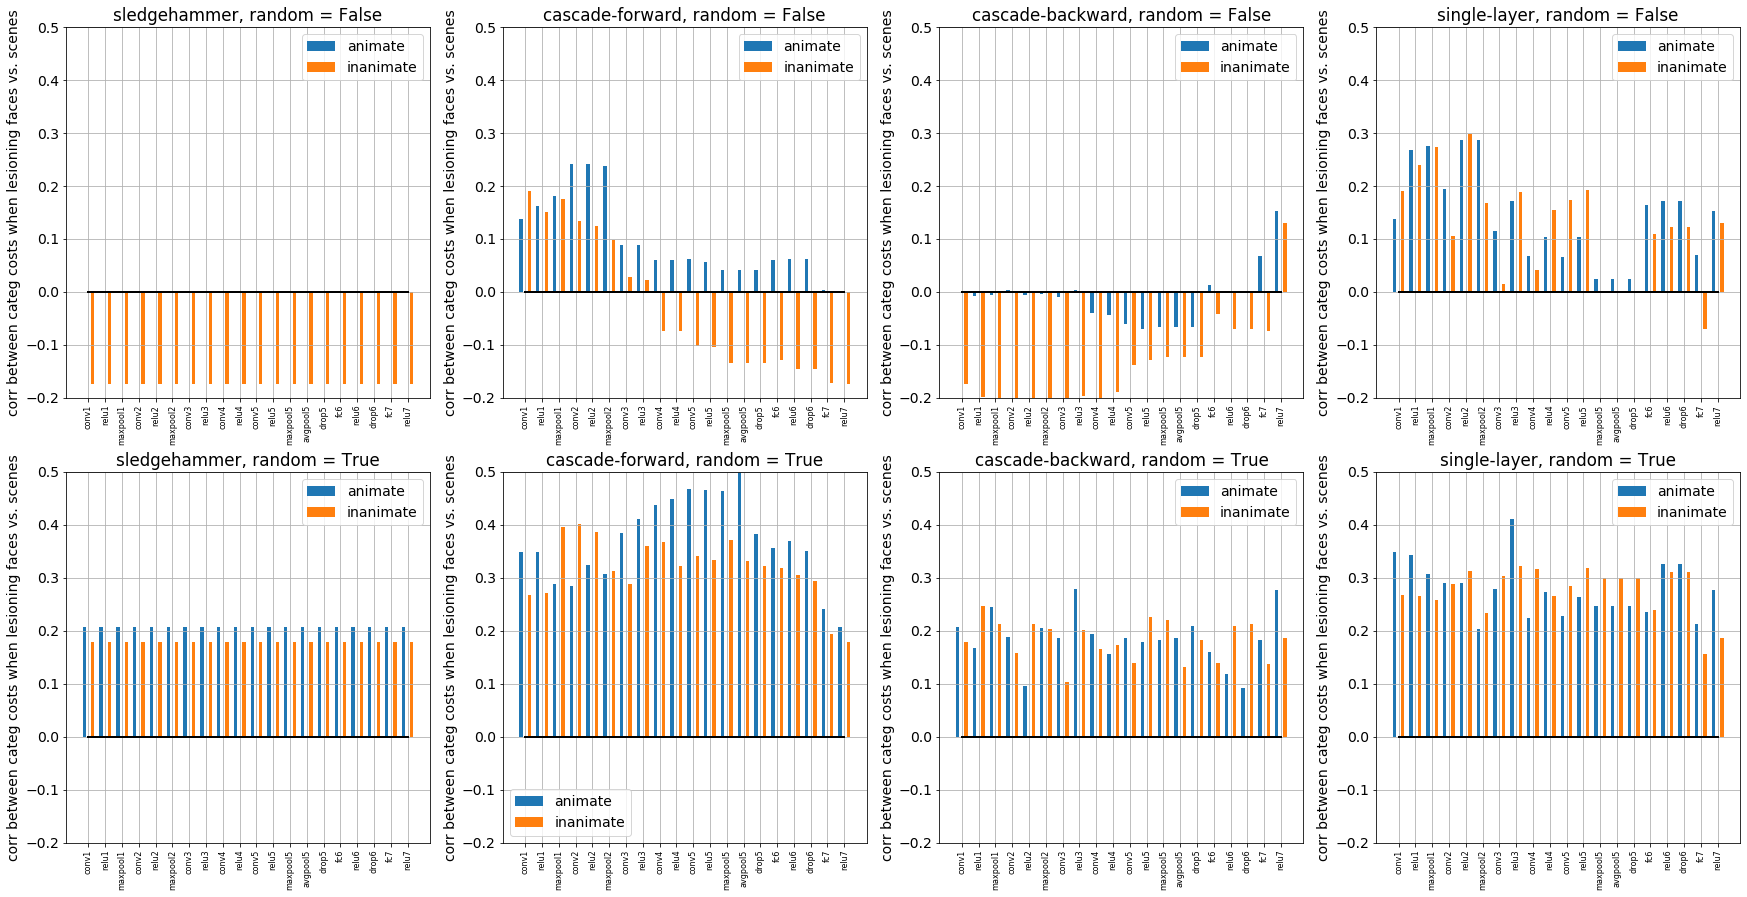

In [282]:
plt.rcParams.update({'font.size': 14})

subplot_order=[1,5,2,6,3,7,4,8]

for animacy_breakdown in [False, True]:

    fig1 = plt.figure(figsize=(30,15))
    c=0
    for lesioning_method in ['sledgehammer','cascade-forward','cascade-backward','single-layer']:
        for randomize_lesions in [False, True]:

            fs_cost_corrs = []
            fs_cost_corrs_an = []
            fs_cost_corrs_inan = []
            
            for lay in model.layers[:-1]:

                if lesioning_method == 'sledgehammer':
                    target_str = ''
                else:
                    target_str = '_target-' + lay

                results_str_faces = f'LesionResults_dim-{img_dim}_FDR-{FDR_str}_subset-{subset_by}_method-{lesioning_method}_random-{str(randomize_lesions)}{target_str}_domain-Faces'
                results_str_scenes = f'LesionResults_dim-{img_dim}_FDR-{FDR_str}_subset-{subset_by}_method-{lesioning_method}_random-{str(randomize_lesions)}{target_str}_domain-Scenes'

                try:
                    fn = join(lesion_resultsdir,results_str_faces + '.npy')
                    results = np.load(fn,allow_pickle=True).item()
                    x = results['no_lesion']['accuracies'] - results['Faces']['accuracies'] 

                    fn = join(lesion_resultsdir,results_str_scenes + '.npy')
                    results = np.load(fn,allow_pickle=True).item()
                    y = results['no_lesion']['accuracies'] - results['Scenes']['accuracies'] 

                    fs_cost_corrs.append(np.corrcoef(x,y)[1,0])
                    fs_cost_corrs_an.append(np.corrcoef(x[:500],y[:500])[1,0])
                    fs_cost_corrs_inan.append(np.corrcoef(x[500:],y[500:])[1,0])

                except:
                    #print('file does not exist')
                    #print(fn)
                    
                    fs_cost_corrs.append(np.nan)
                    fs_cost_corrs_an.append(np.nan)
                    fs_cost_corrs_inan.append(np.nan)

            if animacy_breakdown:
                
                plt.subplot(2,4,subplot_order[c])
                p1 = plt.bar(np.arange(len(model.layers[:-1]))-0.25, fs_cost_corrs_an, width=0.2)
                p2 = plt.bar(np.arange(len(model.layers[:-1]))+0.25, fs_cost_corrs_inan, width=0.2)

                plt.legend((p1[0], p2[0]), ('animate', 'inanimate'))
            else:
                plt.subplot(2,4,subplot_order[c])
                p1 = plt.bar(np.arange(len(model.layers[:-1])), fs_cost_corrs, width=0.75)

            plt.ylim([-0.2,0.5])
            plt.title(f'{lesioning_method}, random = {randomize_lesions}')
            plt.xticks(np.arange(len(model.layers[:-1])),np.array(model.layers[:-1]),rotation=90,fontsize=8)
            plt.grid(True)
            plt.ylabel('corr between categ costs when lesioning faces vs. scenes')
            plt.plot(np.arange(0,20),np.zeros((20,)),'k',linewidth=2)
            c+=1



Faces sledgehammer False


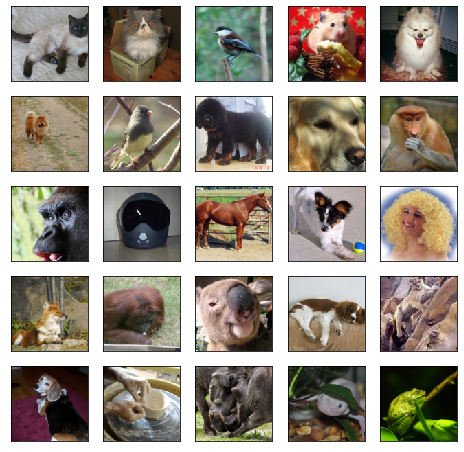

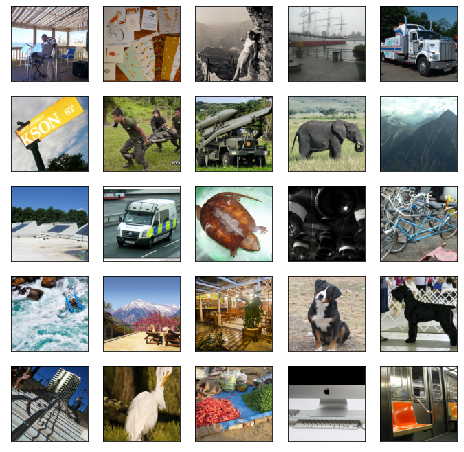

Faces sledgehammer True


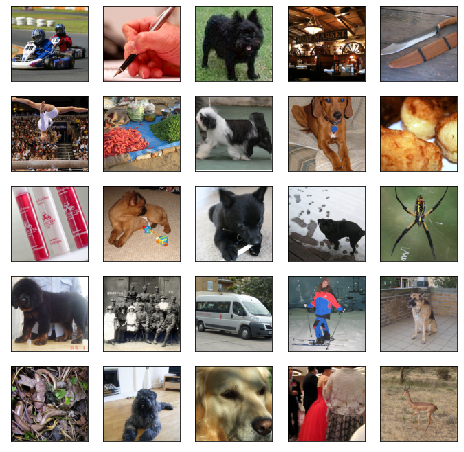

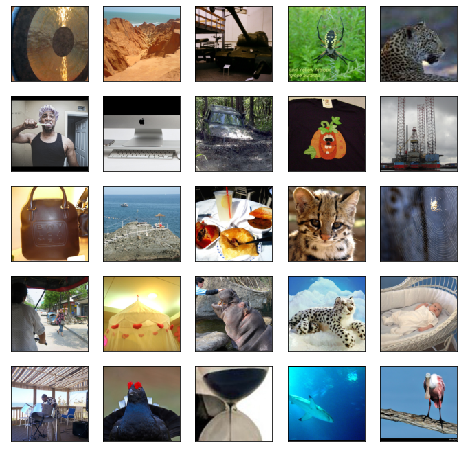

Scenes sledgehammer False


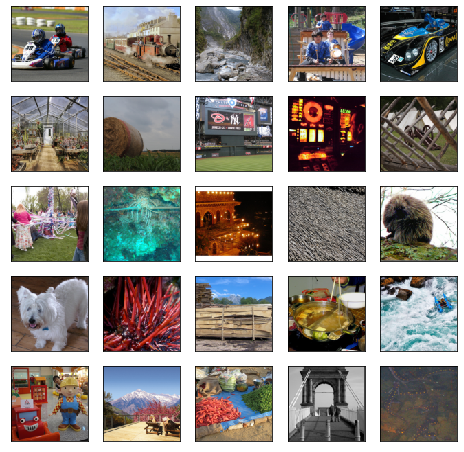

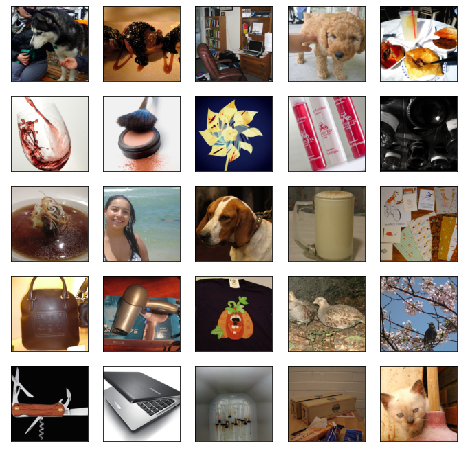

Scenes sledgehammer True


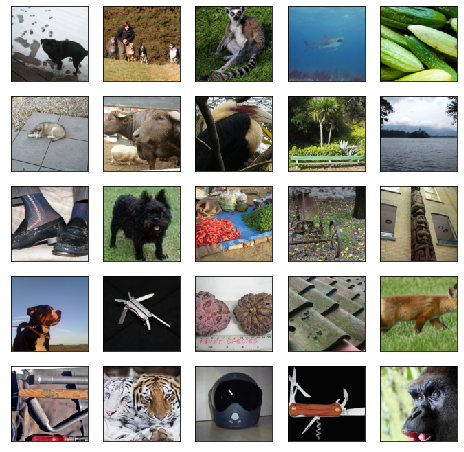

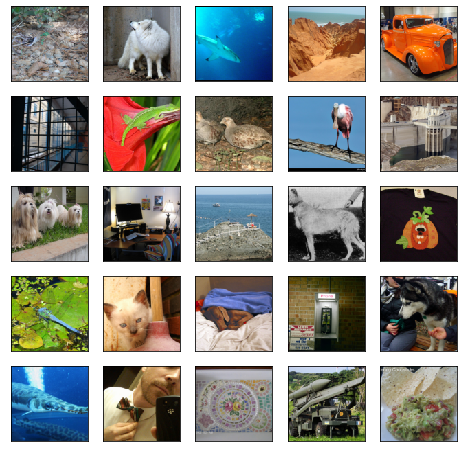

In [303]:


imageset_dir = join(homedir,'imagesets','localizer',imageset)
assert(exists(imageset_dir))

val_imageset_dir = '/lab_data/tarrlab/common/datasets/ILSVRC/Data/CLS-LOC/val/'
assert(exists(val_imageset_dir))

data_transform_ = transforms.Compose([       
transforms.Resize(112),                   
transforms.CenterCrop((112,112))])

val_dataset_ =  datasets.ImageFolder(root = val_imageset_dir, transform = data_transform_)

for lesion_domain in ['Faces','Scenes']:

    for lesioning_method in ['sledgehammer']:#,'cascade-forward','cascade-backward','single-layer']:
        for randomize_lesions in [False,True]:
            
            print(lesion_domain, lesioning_method, randomize_lesions)

            if lesioning_method == 'sledgehammer':
                target_str = ''
            else:
                target_str = '_target-' + lay

            results_str = f'LesionResults_dim-{img_dim}_FDR-{FDR_str}_subset-{subset_by}_method-{lesioning_method}_random-{str(randomize_lesions)}{target_str}_domain-{lesion_domain}'

            fn = join(lesion_resultsdir,results_str + '.npy')

            try:
                results = np.load(fn,allow_pickle=True).item()

                costs = results['no_lesion']['accuracies'] - results[lesion_domain]['accuracies']

                rankings = np.flip(np.argsort(costs))

                results[lesion_domain]['cost_rankings'] = rankings

                plot_rankings = copy.deepcopy(rankings)
                img_rankings = copy.deepcopy(rankings)
                for r in range(len(rankings)):
                    img_rankings[r] = rankings[r] * 50 + 5
               
                p = 25
                plt.figure(figsize=(8,8))
                c = 1
                for i in range(p):
                    plt.subplot(5,5,c)
                    plt.imshow(val_dataset_[img_rankings[i]][0])
                    plt.xticks([])
                    plt.yticks([])
                    plt.axis('tight')
                    ax = plt.gca()
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)
                    c += 1
                plt.show()
                
                plt.figure(figsize=(8,8))
                c = 1
                img_rankings_flipped = np.flip(copy.deepcopy(img_rankings))
                p = 25
                for i in range(p):
                    plt.subplot(5,5,c)
                    plt.imshow(val_dataset_[img_rankings_flipped[i]][0])
                    plt.xticks([])
                    plt.yticks([])
                    plt.axis('tight')
                    ax = plt.gca()
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)
                    c += 1
                plt.show()
            except:
                print('ah')
                pass


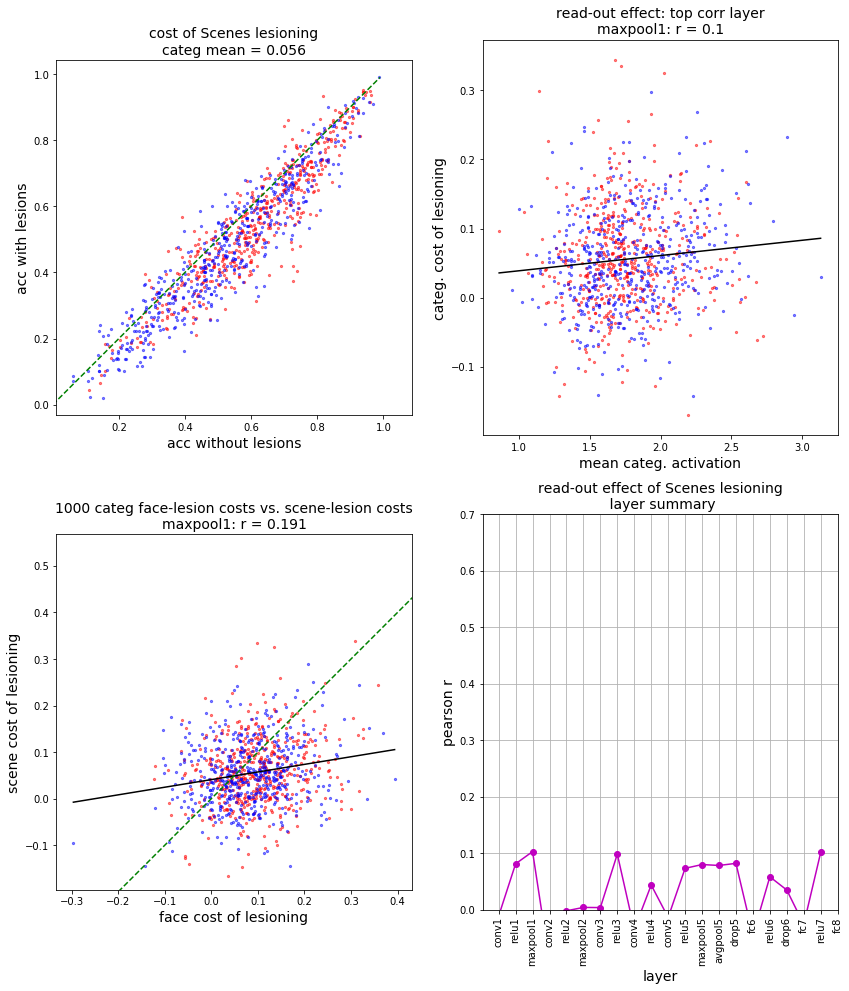

In [124]:
epsilon = 0.0075

costs = results['no_lesion']['accuracies'] - results[lesion_domain]['accuracies']

plt.figure(figsize=(14,16))
plt.subplot(221)
e = np.random.normal(0,epsilon,1000)
x = results['no_lesion']['accuracies'] + e
e = np.random.normal(0,epsilon,1000)
y = results[lesion_domain]['accuracies'] + e
plt.scatter(x[:500],y[:500],5,'r',alpha=0.5)
plt.scatter(x[500:],y[500:],5,'b',alpha=0.5)
mean_cost = np.mean(costs)
plt.axis('square')
plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01),'g--')
plt.xlabel('acc without lesions',fontsize=14)
plt.ylabel('acc with lesions',fontsize=14)
plt.title(f'cost of {lesion_domain} lesioning\ncateg mean = {round(mean_cost,3)}',fontsize=14);

corrs = []
for i in range(len(model.layers)):
    lay = model.layers[i]
    x = results['no_lesion']['selective_unit_acts'][lesion_domain][lay]
    y = results['no_lesion']['accuracies'] - results[lesion_domain]['accuracies']
    corr = np.corrcoef(x,y)[1,0]
    corrs.append(round(corr,4))

plt.subplot(224)
plt.plot(np.arange(len(model.layers)),corrs,'mo-')
plt.xticks(np.arange(len(model.layers)), model.layers, rotation = 90);
plt.grid(True)
plt.title(f'read-out effect of {lesion_domain} lesioning\n layer summary',fontsize=14)
plt.ylabel('pearson r',fontsize=14)
plt.xlabel('layer',fontsize=14)
plt.ylim([0,0.7])

corrs = np.array(corrs)
#results[lesion_domain]['readout_effect_corrs'] = corrs

nan_idx = np.isnan(corrs)
corrs[nan_idx] = 0
max_idx = np.argmax(corrs)

x = results['no_lesion']['selective_unit_acts'][lesion_domain][model.layers[max_idx]]
e = np.random.normal(0,epsilon,1000)
y = results['no_lesion']['accuracies'] - results[lesion_domain]['accuracies'] + e

#results[lesion_domain]['topcorr_layer_acts'] = x

plt.subplot(222)
plt.scatter(x[:500],y[:500],5,'r',alpha=0.5)
plt.scatter(x[500:],y[500:],5,'b',alpha=0.5)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),'k')
plt.title(f'read-out effect: top corr layer\n{model.layers[max_idx]}: r = {round(np.corrcoef(x,y)[1,0],3)}',
         fontsize=14)
plt.xlabel('mean categ. activation',fontsize=14)
plt.ylabel('categ. cost of lesioning',fontsize=14)
#plt.ylim([-1,1])

#figfn = '1_CategCost_ReadoutEffect_Summaries.png'
#plt.savefig(join(lesion_resultsdir,figfn),format='png')

if lesion_domain == 'Faces':
    results_str = f'LesionResults_dim-{img_dim}_FDR-{FDR_str}_subset-{subset_by}_method-{lesioning_method}_random-{str(randomize_lesions)}{target_str}_domain-Scenes'
    fn = join(lesion_resultsdir,results_str + '.npy')      
    results_opp = np.load(fn,allow_pickle=True).item()
    e = np.random.normal(0,epsilon,1000)
    x = results['no_lesion']['accuracies'] - results['Faces']['accuracies'] + e
    e = np.random.normal(0,epsilon,1000)
    y = results_opp['no_lesion']['accuracies'] - results_opp['Scenes']['accuracies'] + e
    
elif lesion_domain == 'Scenes':
    results_str = f'LesionResults_dim-{img_dim}_FDR-{FDR_str}_subset-{subset_by}_method-{lesioning_method}_random-{str(randomize_lesions)}{target_str}_domain-Faces'
    fn = join(lesion_resultsdir,results_str + '.npy')      
    results_opp = np.load(fn,allow_pickle=True).item()
    e = np.random.normal(0,epsilon,1000)
    x = results_opp['no_lesion']['accuracies'] - results_opp['Faces']['accuracies'] + e
    e = np.random.normal(0,epsilon,1000)
    y = results['no_lesion']['accuracies'] - results['Scenes']['accuracies'] + e

plt.subplot(223)
plt.scatter(x[:500],y[:500],5,'r',alpha=0.5)
plt.scatter(x[500:],y[500:],5,'b',alpha=0.5)
plt.title(f'1000 categ face-lesion costs vs. scene-lesion costs\n{model.layers[max_idx]}: r = {round(np.corrcoef(x,y)[1,0],3)}',
         fontsize=14)
plt.xlabel('face cost of lesioning',fontsize=14)
plt.ylabel('scene cost of lesioning',fontsize=14)
#plt.xlim([-1,1])
#plt.ylim([-1,1])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),'k')
plt.axis('square')
plt.plot(np.arange(-0.2,1,0.01),np.arange(-0.2,1,0.01),'g--')
plt.show()
